### A dirty little trick to avoid dealing with paths. 

In [1]:
import os
os.chdir('/home/juagudelo/HOMEdev/drought_pred_hybrid/')

In [2]:
os.getcwd()

'/home/juagudelo/HOMEdev/drought_pred_hybrid'

## From here, this notebook is going to be used to evaluate the best model issued from the hyperparameter tuning over the test set.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
from tqdm import tqdm
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, mean_absolute_error

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

import models
import utilities

In [4]:
# Fixing a seed to warrant the reproducibility
torch.manual_seed(21)
np.random.seed(21)

In [5]:
# Initializing the model
batch_size=128
output_weeks=6
# Hyperparameters
hidden_size= 750
num_lstm_layers= 5
embedding_dims= [50, 50, 50, 50, 50, 50, 50, 570]
num_fc_tabular_layers= 6
num_fc_combined_layers= 4
dropout= 0.6

In [6]:
# Importing the list of unique categories for the categorical features
with open(f"data/processed_dataFrames/list_cat.pickle", "rb") as f:
    list_cat = pickle.load(f)

In [7]:
# Setting up the loaders
dfs=utilities.load_dataFrames()
valid_loader=utilities.create_dataLoader(X_static=dfs["X_tabular_valid"],
                                         X_static_cat=dfs["X_tabular_cat_valid"],
                                         X_time=dfs["X_time_valid"],
                                         y_target=dfs["y_target_valid"],
                                         output_weeks=output_weeks,
                                         y_past=None,
                                         batch_size=batch_size,
                                         shuffle=False
                                         )
test_loader=utilities.create_dataLoader(X_static=dfs["X_tabular_test"],
                                        X_static_cat=dfs["X_tabular_cat_test"],
                                        X_time=dfs["X_time_test"],
                                        y_target=dfs["y_target_test"],
                                        output_weeks=output_weeks,
                                        y_past=None,
                                        batch_size=batch_size,
                                        shuffle=False
                                        )

In [8]:
dfs["X_tabular_cat_valid"].shape

(2457, 8)

In [9]:
test = iter(valid_loader)
X_static, X_static_cat, X_time, y_target = next(test)

In [10]:
class New_HybridModel(nn.Module):
    """
    The last version of the HybridModel, with the same architecture but smalle changes in the forward method and in the embeddings traitement.
    """
    def __init__(
        self,
        num_numerical_features,
        num_time_series_features,
        hidden_size,
        num_lstm_layers,
        list_unic_cat,
        embedding_dims,
        num_fc_tabular_layers,
        num_fc_combined_layers,
        output_size,
        dropout,
        ablation_TS=False,
        ablation_tabular=False,
        ablation_attention=False,
    ):
        super(New_HybridModel, self).__init__()
        self.num_lstm_layers = num_lstm_layers
        self.hidden_size = hidden_size

        self.embeddings = nn.ModuleList(
                [
                    nn.Embedding(num_embeddings=i, embedding_dim=dimension)
                    for i, dimension in zip(list_unic_cat, embedding_dims)
                ]
            )

        self.after_embeddings = nn.Sequential(
            nn.Linear(int(sum(embedding_dims)), 512), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(64, 16)
        )

        tabular_total_size = num_numerical_features + 16
        tabular_fc_layers = []
        for _ in range(num_fc_tabular_layers):
            tabular_fc_layers.append(nn.Linear(tabular_total_size, tabular_total_size))
            tabular_fc_layers.append(nn.ReLU())
        self.tabular_fc_layers = nn.Sequential(
            *tabular_fc_layers, nn.Linear(tabular_total_size, tabular_total_size)
        )

        # TS branch
        self.lstm = nn.LSTM(
            input_size=num_time_series_features,
            hidden_size=hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.attention = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

        combined_fc_layers = []
        input_dim = tabular_total_size + hidden_size

        for _ in range(num_fc_combined_layers):
            combined_fc_layers.append(nn.Linear(input_dim, hidden_size))
            combined_fc_layers.append(nn.ReLU())
            input_dim = hidden_size
        self.combined_fc_layers = nn.Sequential(
            *combined_fc_layers, nn.Linear(hidden_size, output_size)
        )

    def forward(self, time_series_data, numerical_data, categorical_data):
        batch_size = time_series_data.size(0)
        h0 = torch.zeros(self.num_lstm_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_lstm_layers, batch_size, self.hidden_size).to(device)

        time_series_data = time_series_data.to(torch.float32)
        numerical_data = numerical_data.to(torch.float32)
        categorical_data = categorical_data.to(torch.int64)

        embeddings = [emb(categorical_data[:, i]) for i, emb in enumerate(self.embeddings)]
        x_cat = torch.cat(embeddings, dim=1)
        x_cat = self.after_embeddings(x_cat)
        x_tabular = torch.cat((x_cat, numerical_data), dim=1)
        x1 = self.tabular_fc_layers(x_tabular)

        # Pass the time series data through the LSTM and the attention mechanism
        lstm_out, _ = self.lstm(time_series_data, (h0, c0))
        lstm_out = self.layer_norm(lstm_out) # Apply layer normalization
        attn_weights = F.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)
        # Pass the data through the attention mechanism
        # context_vector = lstm_out[:, -1, :]  # Last time step output

        # Combined MLPs and output
        x2 = self.dropout(context_vector)
        x = torch.cat((x1, x2), dim=1)
        x = self.combined_fc_layers(x)
        return x

In [11]:
device=torch.device("cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device=None))

model = New_HybridModel(
    num_numerical_features=dfs["X_tabular_valid"].shape[-1],
    num_time_series_features=dfs["X_time_valid"].shape[-1],
    hidden_size=hidden_size,
    list_unic_cat=list_cat,
    embedding_dims=embedding_dims,
    num_lstm_layers=num_lstm_layers,
    num_fc_tabular_layers=num_fc_tabular_layers,
    num_fc_combined_layers=num_fc_combined_layers,
    output_size=output_weeks,
    dropout=dropout,
)

model.load_state_dict(torch.load("models/MH_Hyper_New_Hybrid/MH_Hyper_New_Hybrid_3.pt", weights_only=True))
model.to(device)

Using device: cpu
NVIDIA T1000 8GB


New_HybridModel(
  (embeddings): ModuleList(
    (0-4): 5 x Embedding(8, 50)
    (5): Embedding(7, 50)
    (6): Embedding(9, 50)
    (7): Embedding(3110, 570)
  )
  (after_embeddings): Sequential(
    (0): Linear(in_features=920, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.6, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.6, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.6, inplace=False)
    (12): Linear(in_features=64, out_features=16, bias=True)
  )
  (tabular_fc_layers): Sequential(
    (0): Linear(in_features=38, out_features=38, bias=True)
    (1): ReLU()
    (2): Linear(in_features=38, out_features=38, bias=True)
    (3): ReLU()
    (4): Linear(in_features=38, out_features=38, bias=True)
    (5): ReLU()
    (6

In [12]:
def predict(x, static, static_cat):
    out = model(torch.tensor(x), static, static_cat)
    return out

In [62]:
dict_map = {
    "y_pred": [],
    "y_pred_rounded": [],
    # "fips": [],
    # "date": [],
    "y_true": [],
    "week": [],
}
i = 0
for x, static, static_cat, y in tqdm(
    test_loader,# ou test_loader
    desc="validation predictions...",
    ):
    x, static, static_cat, y = x.to(device), static.to(device), static_cat.to(device), y.to(device)
    with torch.no_grad():
        pred = predict(x, static, static_cat).clone().detach()
    for w in range(output_weeks):
        dict_map["y_pred"] += [float(p[w]) for p in pred]
        dict_map["y_pred_rounded"] += [int(p.round()[w]) for p in pred]
        # dict_map["fips"] += [f[1][0] for f in valid_fips[i : i + len(x)]]
        # dict_map["date"] += [f[1][1] for f in valid_fips[i : i + len(x)]]
        dict_map["y_true"] += [float(item[w]) for item in y]
        dict_map["week"] += [w] * len(x)
    i += len(x)
df = pd.DataFrame(dict_map)

validation predictions...:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_1568749/1961147624.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(torch.tensor(x), static, static_cat)
validation predictions...: 100%|██████████| 20/20 [00:33<00:00,  1.70s/it]


In [63]:
df

,y_pred,y_pred_rounded,y_true,week
0,0.054612,0,0.0000,0
1,0.004016,0,0.0000,0
2,0.144183,0,0.0000,0
3,0.114944,0,0.0000,0
4,0.014548,0,0.0000,0
...,...,...,...,...
14857,3.072805,3,2.8139,5
14858,3.375255,3,3.1832,5
14859,3.111210,3,2.7126,5
14860,1.876573,2,2.0000,5


In [64]:
for w in range(6):
    wdf = df[df['week']==w]
    mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    f1 = f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)
    print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")

Week 1 MAE 0.165 F1 0.654
Week 2 MAE 0.236 F1 0.612
Week 3 MAE 0.289 F1 0.573
Week 4 MAE 0.345 F1 0.536
Week 5 MAE 0.39 F1 0.501
Week 6 MAE 0.427 F1 0.463


In [65]:
for cat in sorted(df["y_true"].round().astype(int).unique()):
    df_cat = df[df["y_true"].round().astype(int) == cat]
    print(f"Category {cat}")
    print((df_cat["y_true"].round() == df_cat["y_pred"].round()).mean())

Category 0
0.890967519798003
Category 1
0.5613342898134863
Category 2
0.515625
Category 3
0.5720081135902637
Category 4
0.5646123260437376
Category 5
0.6875


[np.float64(0.890967519798003), np.float64(0.5613342898134863), np.float64(0.515625), np.float64(0.5720081135902637), np.float64(0.5646123260437376), np.float64(0.6875)]


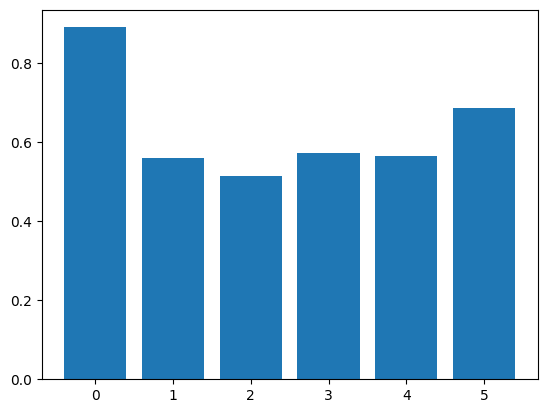

In [66]:
#accuracy bar plot for each category
accuracy = []
for cat in sorted(df["y_true"].round().astype(int).unique()):
    df_cat = df[df["y_true"].round().astype(int) == cat]
    accuracy.append((df_cat["y_true"].round() == df_cat["y_pred"].round()).mean())
plt.bar(sorted(df["y_true"].round().astype(int).unique()), accuracy)

print(accuracy)

In [67]:
from sklearn.metrics import roc_auc_score, root_mean_squared_error, mean_squared_error

Text(0.5, 1.0, 'Mean Squared Error for each week')

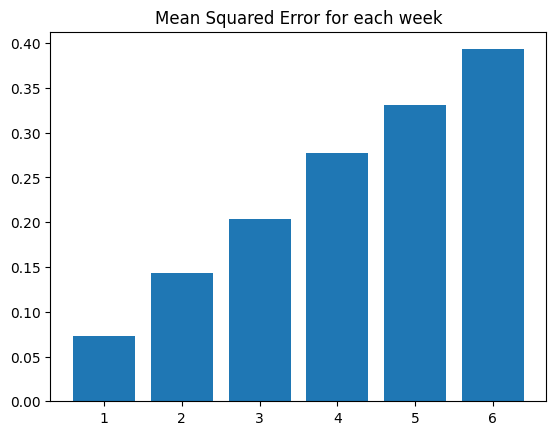

In [76]:
# MAE plot for each week
mse = []
for w in range(6):
    wdf = df[df['week']==w]
    mse.append(mean_squared_error(wdf['y_true'], wdf['y_pred']))
plt.bar(range(1,7), mse)
plt.title("Mean Squared Error for each week")

Text(0.5, 1.0, 'F1 score for each week')

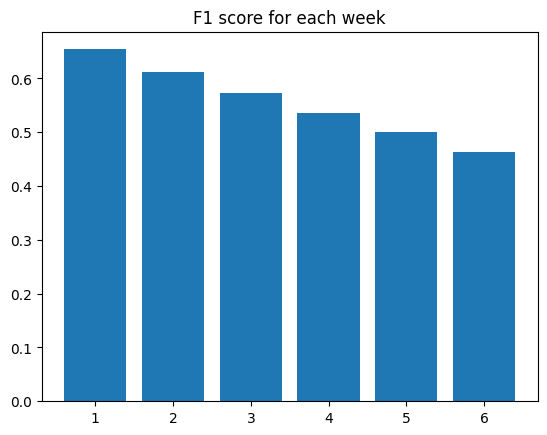

In [73]:
# F1 plot for each week
f1 = []
for w in range(6):
    wdf = df[df['week']==w]
    f1.append(f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro'))
plt.bar(range(1,7), f1)
plt.title("F1 score for each week")

In [70]:
y_true_roc = df['y_true'].round()
y_pred_roc = df['y_pred'].round()
mae = mean_absolute_error(df['y_true'], df['y_pred'])
rmse = root_mean_squared_error(df['y_true'], df['y_pred'])
f1 = f1_score(y_true_roc, y_pred_roc, average='macro')
# do a table using print in the terminal
print("  MAE  | RMSE  |  F1  ")
print(f"{mae} | {rmse} | {f1}")

  MAE  | RMSE  |  F1  
0.3086914665218569 | 0.486893228688281 | 0.5555733728957736


In [71]:
y_pred_roc.unique()

array([0., 1., 2., 5., 3., 4., 6.])

(array([5.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 6.000e+00,
        1.100e+01, 1.200e+01, 9.000e+00, 2.800e+01, 2.000e+01, 3.900e+01,
        7.500e+01, 9.900e+01, 1.690e+02, 2.180e+02, 3.160e+02, 7.570e+02,
        1.570e+03, 3.451e+03, 4.230e+03, 9.280e+02, 7.550e+02, 5.620e+02,
        4.990e+02, 4.670e+02, 2.440e+02, 1.250e+02, 6.500e+01, 4.800e+01,
        5.300e+01, 5.600e+01, 1.900e+01, 9.000e+00, 3.000e+00, 3.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([-3.32589602, -3.16205207, -2.99820811, -2.83436416, -2.6705202 ,
        -2.50667625, -2.34283229, -2.17898834, -2.01514438, -1.85130043,
        -1.68745647, -1.52361252, -1.35976856, -1.19592461, -1.03208065,
        -0.8682367 , -0.70439274, -0.54054879, -0.37670483, -0.21286088,
        -0.04901692,  0.11482703,  0.27867099,  0.44251494,  0.6063589 ,
         0.77020285,  0.93404681,  1.09789076,  1.26173472,  1.42557867,
         1.58942263,  1.75326658,  1.91711054,  2.08095449,  2.2

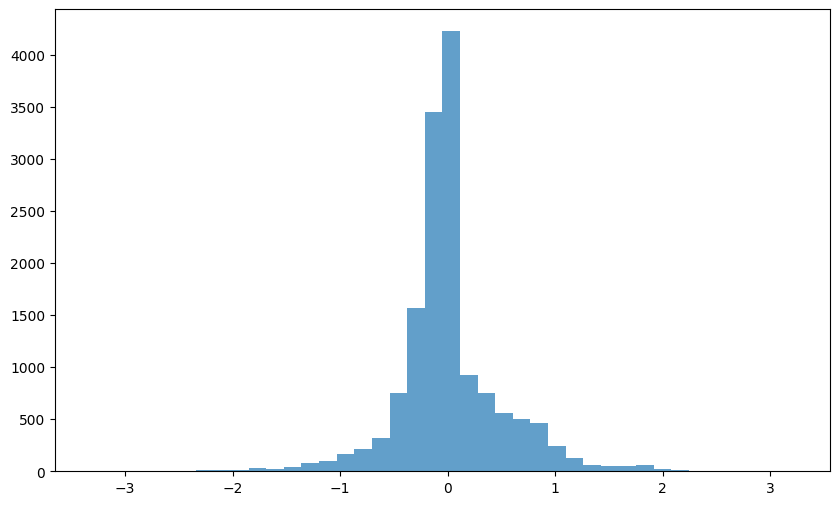

In [72]:
# Error distribution
plt.figure(figsize=(10, 6))
plt.hist((df['y_true'] - df['y_pred']), bins=40, alpha=0.7, label='error')